Comparison of 2003 spin-up at the Juan de Fuca bounday with IOS cruise data. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import datetime
import glob

from salishsea_tools import viz_tools
from salishsea_tools import tidetools
from salishsea_tools import nc_tools
from salishsea_tools.nowcast import figures

from scipy import interpolate as interp

In [2]:
def read_IOS_file(filename,i_stn):
    filehandle = open(filename,'rt')
    with filehandle as data:
            headerover = False
            for line in data:
                if headerover:
                    word = line.split()
                    ss_depth[i_stn,count[i_stn]] = float(word[0])
                    ss_sal[i_stn,count[i_stn]] = float(word[5])
                    ss_temp[i_stn,count[i_stn]] = float(word[1])
                    count[i_stn] = count[i_stn] + 1
                elif line[0:14] == "*END OF HEADER":
                    headerover = True
                else:
                    word = line.split()
                    if len(word) > 1:
                        if word[0] == "LATITUDE":
                            lat = float(word[2])+ float(word[3])/60
                            lats[i_stn]=lat
                        if word[0] == "LONGITUDE":
                            lon = -(float(word[2])+ float(word[3])/60)
                            lons[i_stn]=lon
                        if word[0] == "START":
                            string = word[4] +' ' + word[5]
                            time = datetime.datetime.strptime(string,'%Y/%m/%d %H:%M:%S.%f')
                            times.append(time)
    return lat,lon,time


Read IOS data

In [3]:
files =glob.glob('/ocean/sallen/allen/research/MEOPAR/IOS_2003_CTD/2003-07/CTD/*')
files.sort(key=os.path.basename)
#initilize arrays
nsamps=len(files) #number of samples
ss_depth = np.empty((nsamps,500)); ss_depth.fill('NaN')
ss_sal = np.empty((nsamps,500)); ss_sal.fill('NaN')
ss_temp = np.empty((nsamps,500)); ss_temp.fill('NaN')
count = np.zeros((nsamps), dtype=np.int)
lats=np.zeros(nsamps); lons=np.zeros(nsamps); times=[]
i_stn=0
#Loop through files
for filename in files:
    lat,lon,time=read_IOS_file(filename,i_stn)
    i_stn=i_stn+1
times=np.array(times)

Load model

In [4]:
path='/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/21apr30apr/SalishSea_1d_20030421_20030430_grid_T.nc'
gridT=nc.Dataset(path)
sal_m = gridT.variables['vosaline']
temp_m=gridT.variables['votemper']
depth_m=gridT.variables['deptht']

grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

Isolate point of interest

<matplotlib.contour.QuadContourSet instance at 0x7f46ab702170>

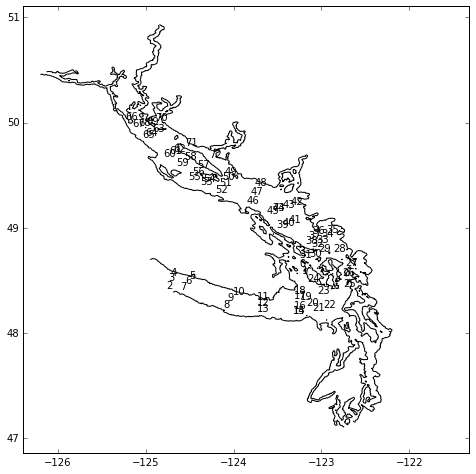

In [5]:
fig,ax=plt.subplots(1,1,figsize=(8,8))

for n in range(times.shape[0]):
    ax.plot(lons[n],lats[n])
    ax.annotate(n,xy=(lons[n],lats[n]))
viz_tools.plot_coastline(ax,grid_B,coords='map')

In [6]:
def compare_fields(date,n,smin=23,smax=34,tmin=6,tmax=11,figsize=(20,8)):
    """ Compares IOS observations with model results on a date at IOS station n
    """
    
    fig,axs=plt.subplots(1,2,figsize=figsize)
    #Isolate model date
    tind = date.day - 21
    time_m=nc_tools.timestamp(gridT,tind)
    
    #Loop through obervations. For ones on date, plot salinity vs longitude for obs and model.
    sal_model=[];sal_obs=[]; lon_plotm=[]; lon_ploto=[]; lat_ploto=[]; lat_plotm=[]
    temp_model=[]; temp_obs=[]
    if times[n].day == date.day:
        #observations data
        sal_obs=ss_sal[n,:];
        dep_obs = ss_depth[n,:]
        temp_obs = ss_temp[n,:]
            
        # model data
        [j,i]=tidetools.find_closest_model_point(lons[n],lats[n],X,Y,bathy,allow_land=False)
        if not isinstance(j,list): #check in domain
            #salinity
            sal_model=sal_m[tind,:,j,i]
             #mask
            mu=sal_model==0; sal_model=np.ma.array(sal_model,mask=mu)
            #temperature
            temp_model=temp_m[tind,:,j,i]
            #mask
            mu=temp_model==0; temp_model=np.ma.array(temp_model,mask=mu)
    
    #salinty plot
    ax=axs[0]
    ax.plot(sal_model[:],depth_m[:],'bo-',label='Model')
    ax.plot(sal_obs,dep_obs,'rs--',label='Observation')
    ax.legend(loc=0)
    ax.set_xlabel('Practical Salinity [psu]'); ax.set_ylabel('depth')
    ax.set_title('Salinity on {date}'.format(date=date.strftime('%d-%b-%Y')))
    ax.set_xlim([smin,smax])
    ax.invert_yaxis()
    ax.grid()
    #temperature plot
    ax2 = axs[1]
    ax2.plot(temp_model[:],depth_m[:],'bo-',label='Model')
    ax2.plot(temp_obs,dep_obs,'rs--',label='Observation')
    ax2.legend(loc=0)
    ax2.set_xlim([tmin,tmax])
    ax2.invert_yaxis()
    ax2.set_xlabel('Temperature (deg C)'); ax2.set_ylabel('depth')
    ax2.set_title('Temperature on {date}'.format(date=date.strftime('%d-%b-%Y')))
    ax2.grid()
    #map
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    ax.plot(lons[n],lats[n],'o')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    viz_tools.plot_coastline(ax,grid_B,coords='map')
    

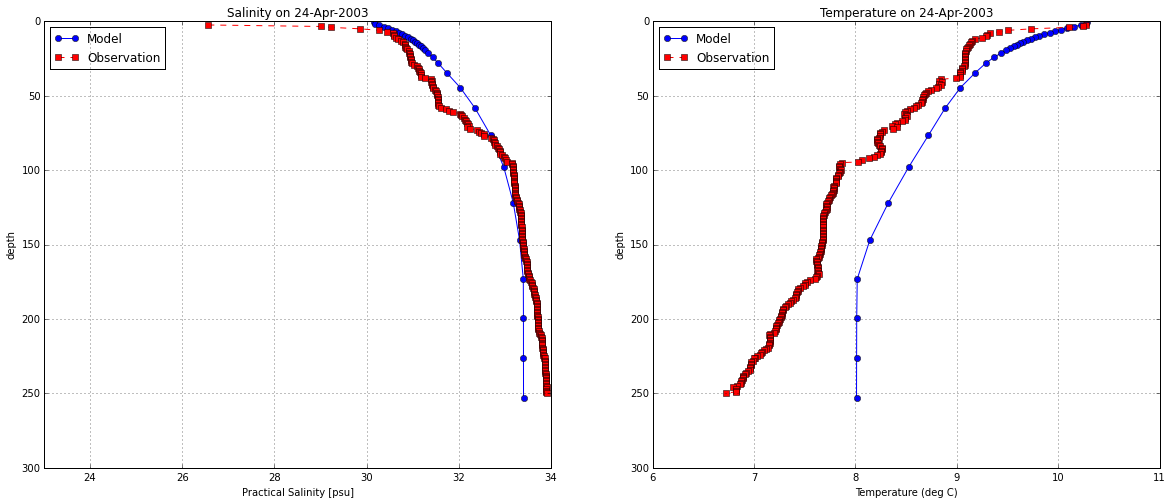

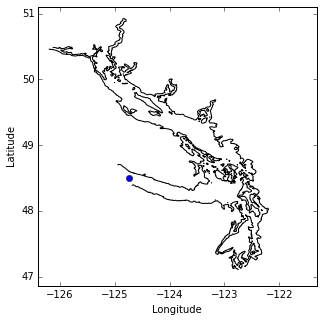

In [7]:
compare_fields(datetime.datetime(2003,4,24),3)

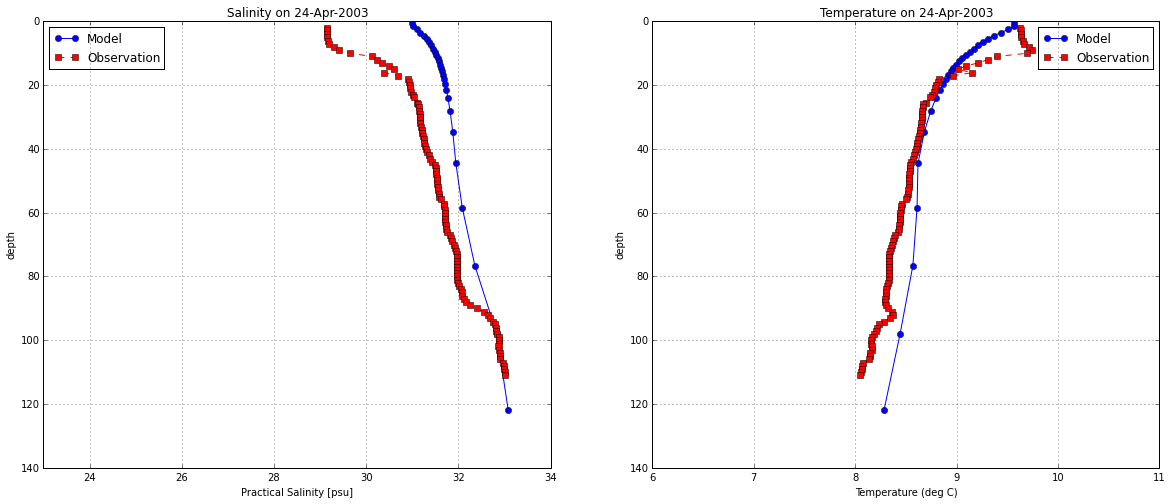

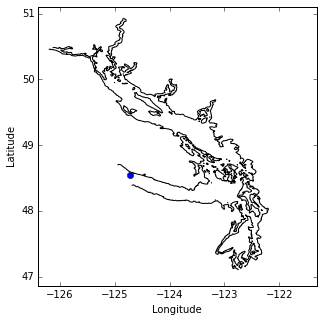

In [8]:
compare_fields(datetime.datetime(2003,4,24),4)

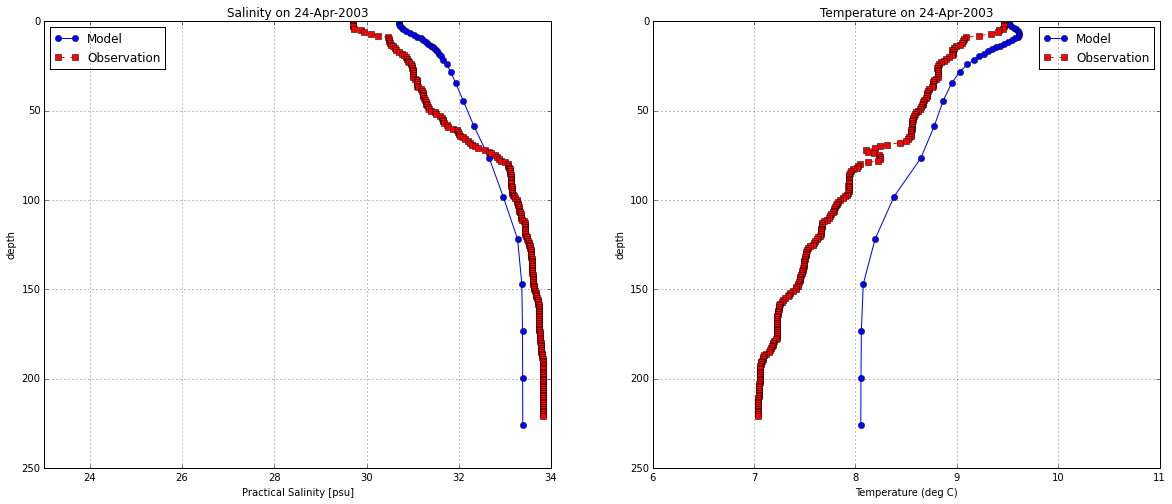

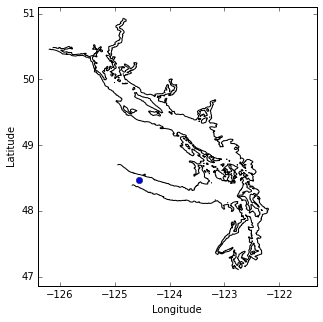

In [9]:
compare_fields(datetime.datetime(2003,4,24),6)

Variability of boundary conditions over time

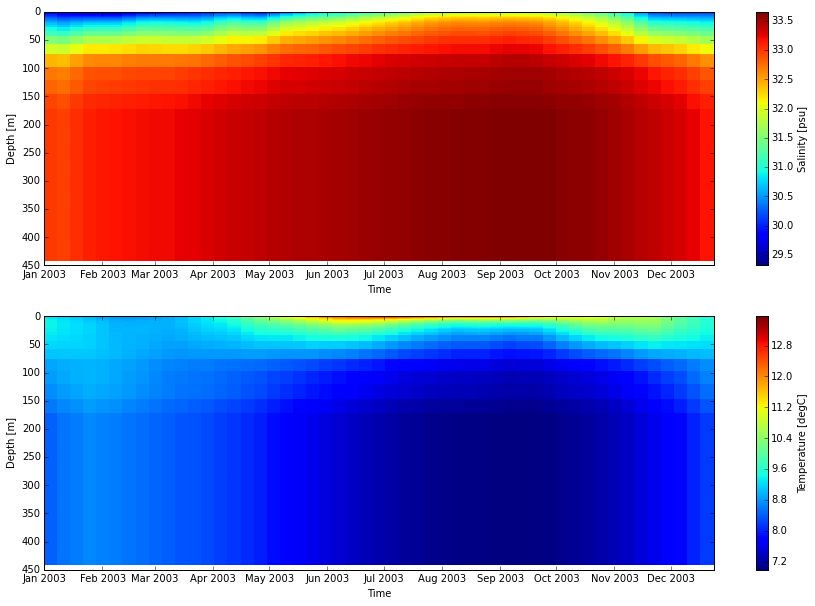

In [10]:
fil = '/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc'
f=nc.Dataset(fil)
sal = f.variables['vosaline']
temp = f.variables['votemper']
dep = f.variables['deptht'][:]
#weekly data, guessing that t=0 corresponds to Jan 1.
tim = f.variables['time_counter'][:]
to=datetime.datetime(2003,1,1)
#construct datetimes
dts = [to + datetime.timedelta(days=7*(week-1)) for week in tim]
dts=np.array(dts)
#plot
fig,axs=plt.subplots(2,1,figsize=(15,10))
#salinty
ax=axs[0]
mesh=ax.pcolormesh(dts,dep,sal[:,:,0,0].T)
ax.invert_yaxis()
ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Salinity [psu]')
#temperature
ax=axs[1]
mesh=ax.pcolormesh(dts,dep,temp[:,:,0,0].T)
ax.invert_yaxis()
ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Temperature [degC]')

# Summary

* In the deep (below 200 m), the model boundary conditions may be too fresh (~0.5 psu) and too warm (>1 deg C).
* If our incoming water is not salty enough, then how does that effect deep water renewal? Our nowcasts are too fresh and too warm in the SoG basin. 
* We are forcing with climatology, so we won't capture the interannual variability of the temperature/salinity of the incoming waters. How important is the incoming water for the renewal events?

#Next steps

* Is there other data we can compare with? Maybe it's about time to look at what Rob has.